# simulator.ipynb
This is the main Jupyter notebook used to document progress and understanding of the current code library for the SPM.

The main library referenced in this notebook will be https://github.com/RichardLiuCoding/spmsimu/, used to simulate traces and retraces.

In [1]:
# Install the required libraries
%pip install -r requirements.txt

  Using cached aespm-1.1.3-py3-none-any.whl.metadata (1.0 kB)
  Using cached igor2-0.5.12-py3-none-any.whl.metadata (2.9 kB)
  Using cached paramiko-3.5.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached Pyro5-5.15-py3-none-any.whl.metadata (4.9 kB)
  Using cached bcrypt-4.3.0-cp39-abi3-macosx_10_12_universal2.whl.metadata (10 kB)
  Using cached cryptography-45.0.3-cp311-abi3-macosx_10_9_universal2.whl.metadata (5.7 kB)
  Using cached PyNaCl-1.5.0-cp36-abi3-macosx_10_10_universal2.whl.metadata (8.7 kB)
  Using cached cffi-1.17.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (1.5 kB)
  Using cached pycparser-2.22-py3-none-any.whl.metadata (943 bytes)
  Using cached serpent-1.41-py3-none-any.whl.metadata (5.8 kB)
Using cached aespm-1.1.3-py3-none-any.whl (24 kB)
Using cached igor2-0.5.12-py3-none-any.whl (32 kB)
Using cached paramiko-3.5.1-py3-none-any.whl (227 kB)
Using cached bcrypt-4.3.0-cp39-abi3-macosx_10_12_universal2.whl (498 kB)
Using cached cryptography-45.0.3-cp311-abi3-macosx_10

In [2]:
# Import required components
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from spmsimu.simulator import *


Now that the basic components have been imported, we can assess the possibilities of the simulator in creating traces and retraces.


Generate the kernel for double tip, with tip1: [x_width, y_width, tip_height]
The two tips are separated by offset.
Everything is in the unit of pixels.



array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], shape=(256, 256))

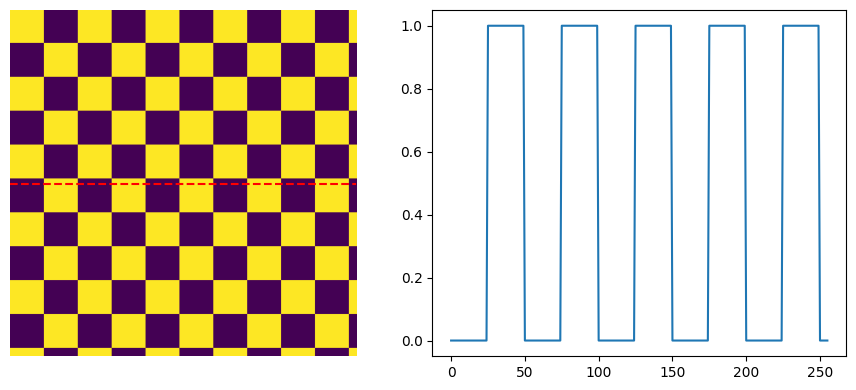

In [3]:
print(generate_doubletip_kernel.__doc__)
checkerboard = generate_pattern(nx=256, ny=256, pattern='checkerboard', num=10, show=True)

# The value of the generation is a 2D map with a singular value that determines its height.
checkerboard[:, :]

The function call to generate images uses the horizontal line (red-dashed) to show
hat you can define the region at which you scan.

This is important for the scanning probe microscope as it allows us to directly correlate
the relationship between what we "see" and what the data actually looks like.

For the simulator in this case, we know that we are working with 2D numpy arrays with a single
variable attached to each point in the array.

This leads us to having the ability to use **point-based estimation** for errors, if needed.

Instead, for now, let us define a way to pass in a function to define the image.

array([[  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.],
       ...,
       [  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.],
       [  0.,   1.,   2., ..., 253., 254., 255.]], shape=(256, 256))

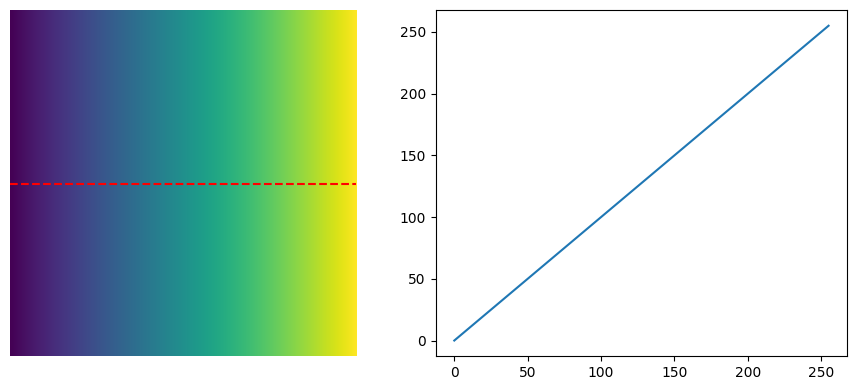

In [4]:
def generate_function_pattern(nx, ny, function = np.ceil, show = False):
    """
    This is a function to generate a map within a square region around the origin, given that
    a standard function or lambda is passed in.

    Inputs:
    nx - int:                   Number of pixels in x-direction
    ny - int:                   Number of pixels in y-direction
    function - lambda:          Function to be modeled around origin (center of image)
    show - bool:                If True, show the plot

    Output:
        pattern_map - ndarray:  2D map with generated pattern
    """
    output = np.zeros((nx, ny))

    # With the given default sin function, we can now modify the zeroed array to contain
    # height map values based on the effects of the function. This is just a double-for
    # loop to scan across the grid.
    for y in range(0, ny, 1):
        for x in range (0, nx, 1):
            output[x, y] = function(y)

    if show:
        fig,ax=plt.subplots(1,2,figsize=[9,4])
        ax[0].imshow(output)
        ax[0].axhline(nx//2, linestyle='--', color='red')
        ax[0].axis('off')
        ax[1].plot(output[nx//2,:])
        plt.tight_layout()

    return output
    
# Sample usage
generate_function_pattern(256, 256, function = lambda x: np.ceil(x), show = True)
    

So, now that we can generate any type of function, we can start to assess how errors in traces and retraces occur.

To do some research about the functionality of a SPM, we will look at some of these resources online:
+ https://www.nanophys.kth.se/nanolab/afm/icon/bruker-help/Content/SPM%20Training%20Guide/How%20an%20SPM%20Works.htm
+ https://www.semitracks.com/reference-material/failure-and-yield-analysis/failure-analysis-die-level/scanning-probe-microscopy.php
+ https://en.wikipedia.org/wiki/Scanning_probe_microscopy

## Probe and Scanner
The **probe** is the point of interface between the SPM and the sample material.
The **scanner** controls the precise position of the probe in relation to the surface (vertically and horizontally).

The scanner moves the probe over the material's surface in a precise pattern called the **raster** pattern. These are a series of zig-zag steps covering a square/rectangular area. This brings us to the tracing and retracing of the sample.

Data can be collected as the probe moves **left to right, during the trace**, and **right to left, during the retrace**. The discrepancies between these scanning modes is what we want to reduce and identify in this notebook.

The way that you can *experimentally optimize* the trace and retrace is by checking how they track during tapping mode. There are several methods that you can use to remedy issues with tracking or errors, such as :
+ Adjusting gains
+ Changing scan rate
+ Moving the set point
+ Changing integral/proportional gain

So what we want to do is to be able to first *detect* when a failure occurs with the retrace. We can now connect other repositories to allow us to use sample data.

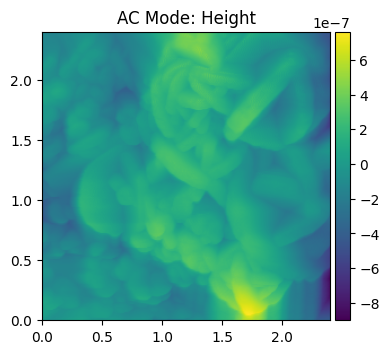

In [9]:
import aespm.tools as at

"""
You can either collect a series of .ibw files in a folder and load them using:
display_ibw_folder(folder, mode=None, key=['Height'], cmaps=None, paras=None, save=None, **kwargs):

Otherwise it is recommended that you use the single-ibw function:
"""
file = "sample_data/good_images/Cs50MA50approx_0003.ibw"
at.display_ibw(file, key = ['Height'])

## Relationship of Images to Data
What we want to do now is take an image file, as shown above, and transfer it into a datastructure that can be manipulated or viewed more easily.

Luckily, the given library allows us to take the data from any object read and store it as a numpy array. What values are stored in this array.



